In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math


from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding, Activation, Input, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing

import tensorflow as tf

from keras.layers import LSTM, Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping

import gensim

In [2]:
df = pd.read_csv('mental_health_dataset.csv',encoding= 'unicode_escape')

In [3]:
df.head

<bound method NDFrame.head of        Unnamed: 0                                        Description  \
0               0  I'm sorry about this post. It's gonna be a who...   
1               1  Been getting super high off high amounts of th...   
2               2  My brothers been shooting heroin/meth for the ...   
3               3  I rlly need an opinion cuz idk bout this stuff...   
4               4  Ive smoked weed since 8th grade in middle scho...   
...           ...                                                ...   
11736       11736  possible have satpathy ask question the questi...   
11737       11737                              god that was thorough   
11738       11738                      thread and meat kaun jat bhai   
11739       11739     not touch food with your left hand left handed   
11740       11740                     they say because they care for   

      Mental_State  
0        Addiction  
1        Addiction  
2        Addiction  
3        Addiction  


In [4]:
df.groupby("Mental_State").describe()

Unnamed: 0                                     \
                            count          mean         std      min   
Mental_State                                                           
Addiction                   998.0    498.500000  288.242086      0.0   
Alcoholism                  999.0   1497.000000  288.530761    998.0   
Anxiety                    1024.0   2508.500000  295.747640   1997.0   
Aspergers                   799.0   3516.000000  230.795725   3117.0   
Bipolar                    1024.0   4427.500000  295.747640   3916.0   
Borderline Personality     1024.0   5720.500000  295.747640   5209.0   
Depression                 1024.0   7018.500000  295.747640   6507.0   
Schizophernia              1024.0   8149.500000  295.747640   7638.0   
SelfHarm                    746.0   9144.857909  215.894415   8772.0   
Suidal Thought             1024.0  10030.500000  295.747640   9519.0   
neutral                    1024.0  11228.500000  295.747640  10717.0   

                                                              
                             25%      50%       75%      max  
Mental_State                                                  
Addiction                 249.25    498.5    747.75    997.0  
Alcoholism               1247.50   1497.0   1746.50   1996.0  
Anxiety                  2252.75   2508.5   2764.25   3020.0  
Aspergers                3316.50   3516.0   3715.50   3915.0  
Bipolar                  4171.75   4427.5   4683.25   4939.0  
Borderline Personality   5464.75   5720.5   5976.25   6232.0  
Depression               6762.75   7018.5   7274.25   7530.0  
Schizophernia            7893.75   8149.5   8405.25   8661.0  
SelfHarm                 8958.25   9144.5   9331.75   9518.0  
Suidal Thought           9774.75  10030.5  10286.25  10542.0  
neutral                 10972.75  11228.5  11484.25  11740.0

In [5]:
df.columns

Index(['Unnamed: 0', 'Description', 'Mental_State'], dtype='object')

In [6]:
df.drop(labels='Unnamed: 0', axis=1)

,Description,Mental_State
0,I'm sorry about this post. It's gonna be a who...,Addiction
1,Been getting super high off high amounts of th...,Addiction
2,My brothers been shooting heroin/meth for the ...,Addiction
3,I rlly need an opinion cuz idk bout this stuff...,Addiction
4,Ive smoked weed since 8th grade in middle scho...,Addiction
...,...,...
11736,possible have satpathy ask question the questi...,neutral
11737,god that was thorough,neutral
11738,thread and meat kaun jat bhai,neutral
11739,not touch food with your left hand left handed,neutral


In [7]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["Mental_State_label"] = lb_make.fit_transform(df["Mental_State"])
df[["Mental_State", "Mental_State_label"]].head(11)

,Mental_State,Mental_State_label
0,Addiction,0
1,Addiction,0
2,Addiction,0
3,Addiction,0
4,Addiction,0
5,Addiction,0
6,Addiction,0
7,Addiction,0
8,Addiction,0
9,Addiction,0


In [8]:
df.isnull()

,Unnamed: 0,Description,Mental_State,Mental_State_label
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
11736,False,False,False,False
11737,False,False,False,False
11738,False,False,False,False
11739,False,False,False,False


In [9]:
df.dropna(inplace=True)

In [10]:
text = df['Description'].values.tolist()

In [11]:
df.groupby("Mental_State").describe()

Unnamed: 0                                     \
                            count          mean         std      min   
Mental_State                                                           
Addiction                   998.0    498.500000  288.242086      0.0   
Alcoholism                  999.0   1497.000000  288.530761    998.0   
Anxiety                    1024.0   2508.500000  295.747640   1997.0   
Aspergers                   799.0   3516.000000  230.795725   3117.0   
Bipolar                    1024.0   4427.500000  295.747640   3916.0   
Borderline Personality     1024.0   5720.500000  295.747640   5209.0   
Depression                 1024.0   7018.500000  295.747640   6507.0   
Schizophernia              1024.0   8149.500000  295.747640   7638.0   
SelfHarm                    746.0   9144.857909  215.894415   8772.0   
Suidal Thought             1024.0  10030.500000  295.747640   9519.0   
neutral                    1024.0  11228.500000  295.747640  10717.0   

                                                              \
                             25%      50%       75%      max   
Mental_State                                                   
Addiction                 249.25    498.5    747.75    997.0   
Alcoholism               1247.50   1497.0   1746.50   1996.0   
Anxiety                  2252.75   2508.5   2764.25   3020.0   
Aspergers                3316.50   3516.0   3715.50   3915.0   
Bipolar                  4171.75   4427.5   4683.25   4939.0   
Borderline Personality   5464.75   5720.5   5976.25   6232.0   
Depression               6762.75   7018.5   7274.25   7530.0   
Schizophernia            7893.75   8149.5   8405.25   8661.0   
SelfHarm                 8958.25   9144.5   9331.75   9518.0   
Suidal Thought           9774.75  10030.5  10286.25  10542.0   
neutral                 10972.75  11228.5  11484.25  11740.0   

                       Mental_State_label                                     \
                                    count  mean  std   min   25%   50%   75%   
Mental_State                                                                   
Addiction                           998.0   0.0  0.0   0.0   0.0   0.0   0.0   
Alcoholism                          999.0   1.0  0.0   1.0   1.0   1.0   1.0   
Anxiety                            1024.0   2.0  0.0   2.0   2.0   2.0   2.0   
Aspergers                           799.0   3.0  0.0   3.0   3.0   3.0   3.0   
Bipolar                            1024.0   4.0  0.0   4.0   4.0   4.0   4.0   
Borderline Personality             1024.0   5.0  0.0   5.0   5.0   5.0   5.0   
Depression                         1024.0   6.0  0.0   6.0   6.0   6.0   6.0   
Schizophernia                      1024.0   7.0  0.0   7.0   7.0   7.0   7.0   
SelfHarm                            746.0   8.0  0.0   8.0   8.0   8.0   8.0   
Suidal Thought                     1024.0   9.0  0.0   9.0   9.0   9.0   9.0   
neutral                            1024.0  10.0  0.0  10.0  10.0  10.0  10.0   

                              
                         max  
Mental_State                  
Addiction                0.0  
Alcoholism               1.0  
Anxiety                  2.0  
Aspergers                3.0  
Bipolar                  4.0  
Borderline Personality   5.0  
Depression               6.0  
Schizophernia            7.0  
SelfHarm                 8.0  
Suidal Thought           9.0  
neutral                 10.0

In [12]:
df["Mental_State"].value_counts()

Anxiety                   1024
Bipolar                   1024
Borderline Personality    1024
Depression                1024
Schizophernia             1024
Suidal Thought            1024
neutral                   1024
Alcoholism                 999
Addiction                  998
Aspergers                  799
SelfHarm                   746
Name: Mental_State, dtype: int64

C:\Users\moshi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


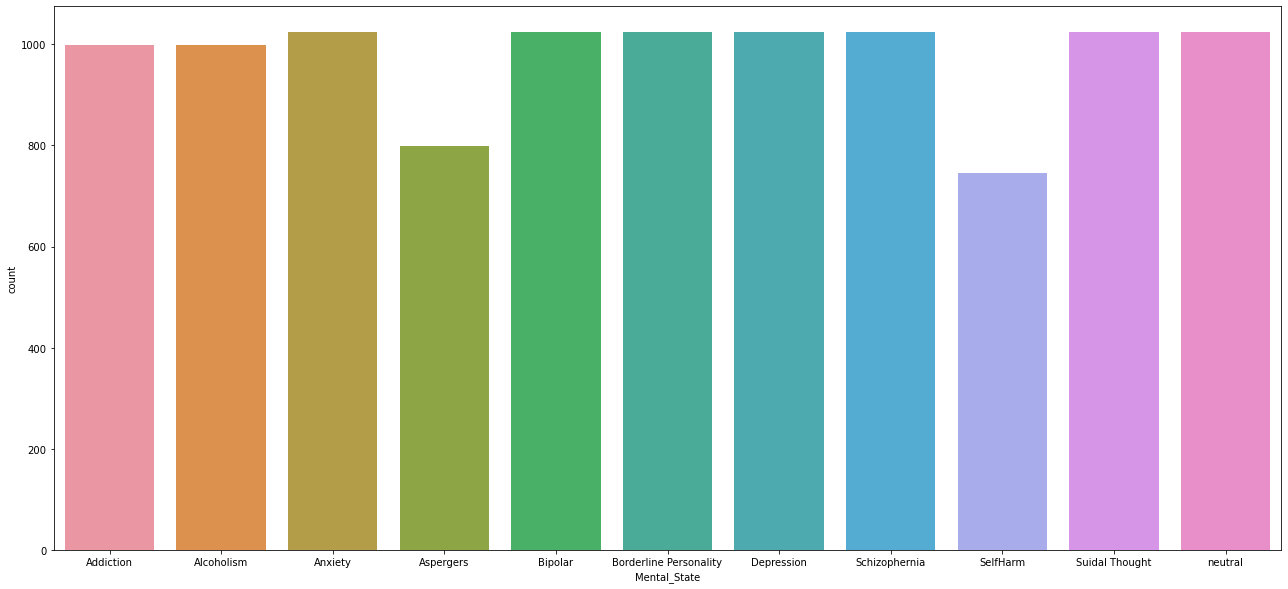

In [13]:
plt.subplots(figsize=(22,10))
sns.countplot(df["Mental_State"])
plt.show()

In [14]:
longest_string = max(df["Description"], key=len)
print(len(longest_string))

26163


In [15]:
import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup

import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer

In [16]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [17]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on description column
df['Description']=df['Description'].apply(denoise_text)

In [18]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on description column
df['Description']=df['Description'].apply(remove_special_characters)

In [19]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on description column
df['Description']=df['Description'].apply(simple_stemmer)

In [20]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['Description']=df['Description'].apply(remove_stopwords)

{'or', 'same', 'once', "should've", 'hadn', "aren't", 'aren', "needn't", "shouldn't", 'while', 'for', 'had', 'whom', 'than', 'those', 'hasn', 'between', 'above', 'needn', "weren't", 'weren', "you'd", 'didn', 'my', "wouldn't", 'myself', 'ourselves', 'nor', 'from', 'through', 'so', "shan't", 'yourself', 'her', 'theirs', 'can', 'ain', 'doing', 'out', 'here', 'they', 'wouldn', 'shan', 'these', 'because', 'does', 'own', "hasn't", 'under', 'then', 'by', 'do', 'most', 'will', 'your', 'that', 'after', 'and', 'both', 'couldn', 'ma', "doesn't", 'yourselves', 'all', 'further', 'am', 'wasn', 'very', 'where', 'ours', 'has', 'was', 'below', 'about', 'just', 'don', 'such', 'its', 'into', 'an', 'should', 'y', 'been', 'o', 'our', 're', 'it', 'not', 'herself', "it's", 'too', 'm', 'isn', 'shouldn', 'himself', 'i', 'haven', 'hers', 'some', 'mightn', 'each', "hadn't", 'now', 'll', "isn't", 's', 'them', 'a', 'him', 'itself', 'more', "don't", 'off', 'are', 'of', "mightn't", 'have', 'against', 'how', 'who', '

In [21]:
longest_string = max(df["Description"], key=len)
print(len(longest_string))

15023


In [22]:
text = df["Description"]

In [23]:
emotion =df["Mental_State"]

In [24]:
print("data shape", df.shape)

data shape (10710, 4)


In [25]:
Mental_Class=df.Mental_State.unique()
dic={}
for i,Mental_State in enumerate(Mental_Class):
    dic[Mental_State]=i
labels=df.Mental_State.apply(lambda x:dic[x])
print(labels)

0         0
1         0
2         0
3         0
4         0
         ..
11736    10
11737    10
11738    10
11739    10
11740    10
Name: Mental_State, Length: 10710, dtype: int64


In [26]:
val_data=df.sample(frac=0.2,random_state=200)
train_data=df.drop(val_data.index)

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [28]:
texts=train_data.Description

In [29]:
NUM_WORDS=20000
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid=tokenizer.texts_to_sequences(val_data.Description)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 18353 unique tokens.


In [30]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])
y_train = to_categorical(np.asarray(labels[train_data.index]))
y_val = to_categorical(np.asarray(labels[val_data.index]))
print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (8568, 2502) (2142, 2502)
Shape of label train and validation tensor: (8568, 11) (2142, 11)


In [31]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('C:/Users/moshi/Python Code/Vietnam and Indonesia/GoogleNews-vectors-negative300.bin', binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)
print(embedding_matrix.shape)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

(18354, 300)


In [32]:
from keras.layers import Embedding
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM)


#calculating max length of the vector
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_val]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 2502


In [33]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = X_train.shape[1]
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [34]:
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

In [35]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIM, weights = [embedding_matrix], input_length=maxlen))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(20)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation=act))
model.add(Dense(64, activation=act))
model.add(Dense(11, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2502, 300)         5506200   
                                                                 
 bidirectional (Bidirectiona  (None, 2502, 40)         51360     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 2502, 40)          0         
                                                                 
 batch_normalization (BatchN  (None, 2502, 40)         160       
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 2502, 40)         9760      
 nal)                                                            
                                                        

In [36]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='test_accuracy',
    mode='max',
    save_best_only=True)

In [37]:
history = model.fit(X_train, y_train, epochs=35,verbose=1, validation_data=(X_val, y_val), batch_size=64,callbacks=[model_checkpoint_callback]) 
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/35
134/134 [==============================] - 1438s 11s/step - loss: 2.3258 - accuracy: 0.1497 - val_loss: 2.2218 - val_accuracy: 0.1788
Epoch 2/35
134/134 [==============================] - 1611s 12s/step - loss: 2.1162 - accuracy: 0.2296 - val_loss: 2.1331 - val_accuracy: 0.2479
Epoch 3/35
134/134 [==============================] - 1601s 12s/step - loss: 1.8110 - accuracy: 0.3266 - val_loss: 1.7207 - val_accuracy: 0.3725
Epoch 4/35
134/134 [==============================] - 1592s 12s/step - loss: 1.5579 - accuracy: 0.3980 - val_loss: 1.6514 - val_accuracy: 0.3959
Epoch 5/35
134/134 [==============================] - 1643s 12s/step - loss: 1.3072 - accuracy: 0.5099 - val_loss: 1.4129 - val_accuracy: 0.5411
Epoch 6/35
134/134 [==============================] - 2281s 17s/step - loss: 1.0662 - accuracy: 0.6174 - val_loss: 1.2687 - val_accuracy: 0.5976
Epoch 7/35
134/134 [==============================] - 2224s 17s/step - loss: 0.8672 - accuracy: 0.6958 - val_loss: 1.2909 - val_ac

134/134 [==============================] - 2107s 16s/step - loss: 0.0941 - accuracy: 0.9748 - val_loss: 2.4957 - val_accuracy: 0.6429
Epoch 28/35
134/134 [==============================] - 2090s 16s/step - loss: 0.0962 - accuracy: 0.9772 - val_loss: 2.4684 - val_accuracy: 0.6601
Epoch 29/35
134/134 [==============================] - 2090s 16s/step - loss: 0.1287 - accuracy: 0.9656 - val_loss: 2.4152 - val_accuracy: 0.6335
Epoch 30/35
134/134 [==============================] - 2031s 15s/step - loss: 0.1007 - accuracy: 0.9747 - val_loss: 2.3013 - val_accuracy: 0.6032
Epoch 31/35
134/134 [==============================] - 2123s 16s/step - loss: 0.0879 - accuracy: 0.9782 - val_loss: 2.4307 - val_accuracy: 0.6457
Epoch 32/35
134/134 [==============================] - 2075s 15s/step - loss: 0.0825 - accuracy: 0.9797 - val_loss: 2.5016 - val_accuracy: 0.6527
Epoch 33/35
134/134 [==============================] - 2098s 16s/step - loss: 0.0730 - accuracy: 0.9818 - val_loss: 2.6422 - val_accurac

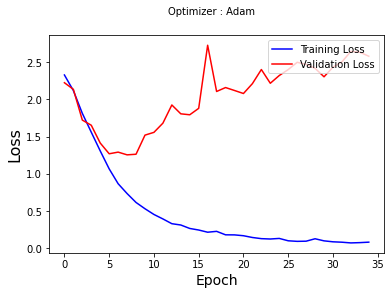

In [38]:
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [39]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.6601307392120361


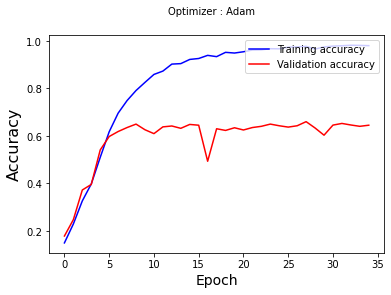

In [40]:
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(history.history['accuracy'], color='b', label='Training accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
plt.legend(loc='upper right')

In [43]:
predict = model.predict(X_val)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

array([ 4,  1,  9, ...,  4, 10,  4], dtype=int64)

In [44]:
from sklearn.metrics import classification_report

print(classification_report(val_data["Mental_State_label"], predict_class, target_names =["Anxiety","Bipolar","Borderline Personality", "Depression ", "Schizophernia","Suidal Thought","neutral",
                                "Alcoholism","Addiction","Aspergers","SelfHarm "]))

                        precision    recall  f1-score   support

               Anxiety       0.69      0.69      0.69       200
               Bipolar       0.80      0.74      0.77       204
Borderline Personality       0.73      0.58      0.65       220
           Depression        0.63      0.66      0.64       177
         Schizophernia       0.74      0.65      0.69       220
        Suidal Thought       0.62      0.61      0.61       195
               neutral       0.38      0.41      0.40       203
            Alcoholism       0.74      0.63      0.68       196
             Addiction       0.52      0.67      0.58       132
             Aspergers       0.49      0.64      0.56       203
             SelfHarm        0.87      0.85      0.86       192

              accuracy                           0.65      2142
             macro avg       0.66      0.65      0.65      2142
          weighted avg       0.66      0.65      0.65      2142

